# Evaluate p-values on Atari100k test results for different algorithms
Author: r.casesa

The aim of this notebook is to compare different Reinforcement Learning algorithms against the Atari 100k benchmark and evaluate results from the paper "Deep Reinforcement Learning at the Edge of the Statistical Precipice".

The mentioned paper shows how evaluating algorithms based on a few sample's mean or median often leads to uncorrect results and proposes alternative metrics for algorithm evaluation.
We extend the treatment by including statistical tests. 

For each algorithm we plot results and test for normality. In fact t-test can be performed only on normally distributed data.
As the data appears to be non/normally distributed two approaches are tried out:
1. Transform the resulting data using a log transformation. This makes sense in general as data is skewed towards higher values of returns
2. Using tests which assume non normality.
3. Bootstrap data

## Question points
1. How do we handle non-normal data?
2. How do we handle the fact that the comparison should be performed on multiple tasks (games)
3. Which metric we can use?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import json
from scipy import stats
import itertools
import math
import seaborn as sns
# import scikit_posthocs


# ALE datapoints

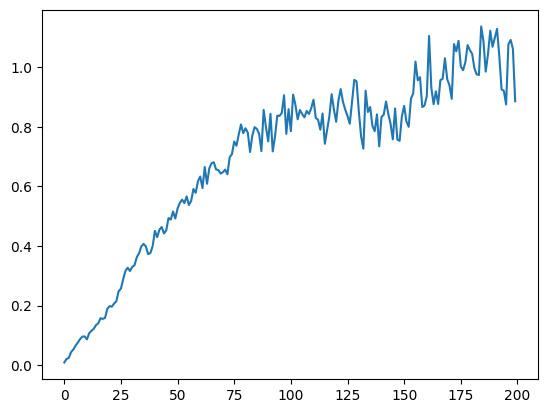

In [2]:
ale = np.load(r"ALE\atari_200_iters_normalized_scores.npy", allow_pickle=True)
ale = ale.tolist()
dqnN = ale['DQN (Nature)']
np.shape(dqnN)

plt.plot(dqnN[:,1,1])

Il risultato è che i data point per ALE sono in realtà relativi a un singolo training. Partono da zero e crescono.

# ATARI 100k
All'interno della cartella atari100k sono presenti 100 punti (simulazioni/game) per i seguenti algoritmi:
1. CURL
2. DER
3. OTrainbow
4. SPR
4. DrQ(eps)
4. DrQ

Per i seguenti algortmi invece:
1. SimPLe contiene 5 punti per game.
2. PlayVirtual contiene 14 punti per game.

In [2]:
with open(r'atari_100k\OTRainbow.json') as ff:
    a100 = json.load(ff)
rain_ret = a100

der_ret = dict()
for root, dirs, files in os.walk(r"atari_100k\DER"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file)) as ff:
                a100 = json.load(ff)
                der_ret.update({file[:-5]: [i['eval_average_return'] for i in a100]})

curl_ret = dict()
for root, dirs, files in os.walk(r"atari_100k\CURL"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file)) as ff:
                a100 = json.load(ff)
                curl_ret.update({file[:-5]: [i['eval_average_return'] for i in a100]})

with open(r'atari_100k\SPR.json') as ff:
    a100 = json.load(ff)
spr_ret = a100

with open(r'atari_100k\DrQ.json') as ff:
    a100 = json.load(ff)
drq_ret = a100

with open(r'atari_100k\DrQ(eps).json') as ff:
    a100 = json.load(ff)
drqeps_ret = a100

algo_bench = {'CURL': curl_ret, 'DER': der_ret, 'DrQ': drq_ret, 'DrQ(eps)': drqeps_ret, 'OTR': rain_ret, 'SPR': spr_ret}

In [3]:
algo_bench

{'CURL': {'Alien': [671.0,
   721.1,
   754.4,
   749.2,
   731.7,
   1026.6,
   1028.1,
   855.3,
   809.0,
   691.9,
   694.0,
   759.9,
   842.1,
   722.8,
   767.8,
   914.3,
   737.1,
   735.3,
   642.0,
   681.2,
   548.5,
   636.3,
   636.1,
   617.8,
   1072.9,
   754.1,
   839.8,
   785.4,
   913.2,
   515.3,
   569.1,
   1155.9,
   418.2,
   781.7,
   602.6,
   672.5,
   819.7,
   871.7,
   628.5,
   596.8,
   612.8,
   641.6,
   781.0,
   727.3,
   708.1,
   827.0,
   1037.0,
   740.7,
   888.4,
   678.1,
   809.5,
   598.0,
   752.7,
   494.5,
   1084.1,
   679.5,
   732.9,
   623.8,
   932.7,
   732.9,
   554.2,
   574.6,
   786.7,
   657.6,
   662.0,
   714.6,
   595.4,
   990.7,
   935.0,
   597.1,
   589.3,
   585.0,
   682.6,
   701.7,
   651.7,
   1431.0,
   607.7,
   630.7,
   780.4,
   714.9,
   780.0,
   615.7,
   577.5,
   838.9,
   1163.0,
   680.8,
   782.3,
   723.7,
   638.9,
   669.8,
   463.0,
   883.3,
   748.9,
   559.2,
   635.7,
   657.9,
   765.4,
   68

In [4]:
games = list(rain_ret.keys())   # take a random algorithm from the list and extract the games. Assumes all algorithms have been tested against the same games.
M = len(games)
Nalgo = len(algo_bench.items())
algo_list = list(algo_bench.keys())

In [6]:
games

['Alien',
 'Amidar',
 'Assault',
 'Asterix',
 'BankHeist',
 'BattleZone',
 'Boxing',
 'Breakout',
 'ChopperCommand',
 'CrazyClimber',
 'DemonAttack',
 'Freeway',
 'Frostbite',
 'Gopher',
 'Hero',
 'Jamesbond',
 'Kangaroo',
 'Krull',
 'KungFuMaster',
 'MsPacman',
 'Pong',
 'PrivateEye',
 'Qbert',
 'RoadRunner',
 'Seaquest',
 'UpNDown']

In [4]:

#@title Record scores on Atari games
record_scores = False

ALL_HUMAN_RECORD = {
  'Alien': 251916.0,
  'Amidar': 104159.0,
  'Assault': 8647.0,
  'Asterix': 1000000.0,
  'Asteroids': 10506650.0,
  'Atlantis': 10604840.0,
  'BankHeist': 82058.0,
  'BattleZone': 801000.0,
  'BeamRider': 999999.0,
  'Berzerk': 1057940.0,
  'Bowling': 300.0,
  'Boxing': 100.0,
  'Breakout': 864.0,
  'Centipede': 1301709.0,
  'ChopperCommand': 999999.0,
  'CrazyClimber': 219900.0,
  'DemonAttack': 1556345.0,
  'DoubleDunk': 22.0,
  'Enduro': 9500.0,
  'FishingDerby': 71.0,
  'Freeway': 38.0,
  'Frostbite': 454830.0,
  'Gopher': 355040.0,
  'Gravitar': 162850.0,
  'Hero': 1000000.0,
  'IceHockey': 36.0,
  'Jamesbond': 45550.0,
  'Kangaroo': 1424600.0,
  'Krull': 104100.0,
  'KungFuMaster': 1000000.0,
  'MontezumaRevenge': 1219200.0,
  'MsPacman': 290090.0,
  'NameThisGame': 25220.0,
  'Phoenix': 4014440.0,
  'Pitfall': 114000.0,
  'Pong': 21.0,
  'PrivateEye': 101800.0,
  'Qbert': 2400000.0,
  'Riverraid': 1000000.0,
  'RoadRunner': 2038100.0,
  'Robotank': 76.0,
  'Seaquest': 999999.0,
  'Skiing': -3272.0,
  'Solaris': 111420.0,
  'SpaceInvaders': 621535.0,
  'StarGunner': 77400.0,
  'Tennis': 21.0,
  'TimePilot': 65300.0,
  'Tutankham': 5384.0,
  'UpNDown': 82840.0,
  'Venture': 38900.0,
  'VideoPinball': 89218328.0,
  'WizardOfWor': 395300.0,
  'YarsRevenge': 15000105.0,
  'Zaxxon': 83700.0,
  'AirRaid': 23050.0,
  'Carnival': 2541440.0,
  'ElevatorAction': 156550.0,
  'JourneyEscape': -4317804.0,
  'Pooyan': 13025.0
}
RANDOM_SCORES = {
 'Alien': 227.8,
 'Amidar': 5.8,
 'Assault': 222.4,
 'Asterix': 210.0,
 'BankHeist': 14.2,
 'BattleZone': 2360.0,
 'Boxing': 0.1,
 'Breakout': 1.7,
 'ChopperCommand': 811.0,
 'CrazyClimber': 10780.5,
 'DemonAttack': 152.1,
 'Freeway': 0.0,
 'Frostbite': 65.2,
 'Gopher': 257.6,
 'Hero': 1027.0,
 'Jamesbond': 29.0,
 'Kangaroo': 52.0,
 'Krull': 1598.0,
 'KungFuMaster': 258.5,
 'MsPacman': 307.3,
 'Pong': -20.7,
 'PrivateEye': 24.9,
 'Qbert': 163.9,
 'RoadRunner': 11.5,
 'Seaquest': 68.4,
 'UpNDown': 533.4
}

HUMAN_SCORES = {
 'Alien': 7127.7,
 'Amidar': 1719.5,
 'Assault': 742.0,
 'Asterix': 8503.3,
 'BankHeist': 753.1,
 'BattleZone': 37187.5,
 'Boxing': 12.1,
 'Breakout': 30.5,
 'ChopperCommand': 7387.8,
 'CrazyClimber': 35829.4,
 'DemonAttack': 1971.0,
 'Freeway': 29.6,
 'Frostbite': 4334.7,
 'Gopher': 2412.5,
 'Hero': 30826.4,
 'Jamesbond': 302.8,
 'Kangaroo': 3035.0,
 'Krull': 2665.5,
 'KungFuMaster': 22736.3,
 'MsPacman': 6951.6,
 'Pong': 14.6,
 'PrivateEye': 69571.3,
 'Qbert': 13455.0,
 'RoadRunner': 7845.0,
 'Seaquest': 42054.7,
 'UpNDown': 11693.2
}

NORM_BASELINE = ALL_HUMAN_RECORD if record_scores else HUMAN_SCORES 


# Data distribution

NormaltestResult(statistic=486.4893446436832, pvalue=2.2918229192995385e-106)

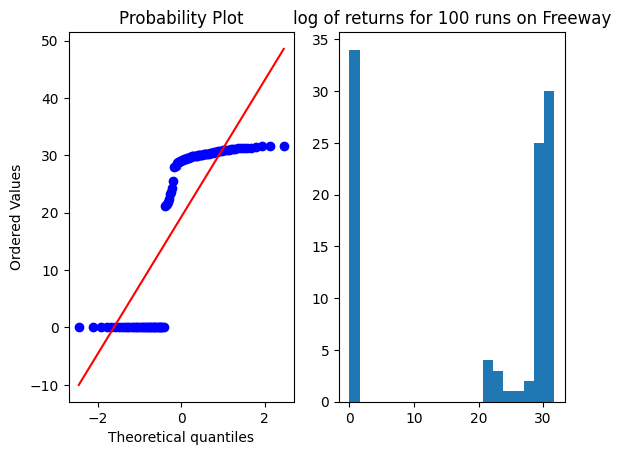

In [6]:
fig = plt.subplot(121)
stats.probplot(algo_bench['SPR']['Freeway'], plot=fig)
plt.subplot(122)
plt.hist(algo_bench['SPR']['Freeway'], bins=20, )
plt.title('log of returns for 100 runs on Freeway')

stats.normaltest(algo_bench['SPR']['Freeway'])

In [7]:
# plt.hist(np.log(der_alien_ret), bins=20)
# fig = plt.subplot(121)
# stats.probplot(der_ret['Alien'], plot=fig)
# plt.subplot(122)
# plt.hist(der_ret['Alien'])
# plt.title('[DER] returns for 100 runs on Alien')

# stats.normaltest((der_ret['Alien']))

In [8]:
# plt.hist(np.log(der_alien_ret), bins=20)
# fig = plt.subplot(121)
# stats.probplot(np.log(rain_ret['Alien']), plot=fig)
# plt.subplot(122)
# plt.hist(np.log(rain_ret['Alien']))
# plt.title('[OTRainbow] returns for 100 runs on Alien')

# stats.normaltest(np.log(rain_ret['Alien']))

OK effettivamente sono presenti 100 punti. La distribuzione può essere quasi normalizzata

c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:1633: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:1738: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


49 samples from a normal distribution out of 156


<Axes: >

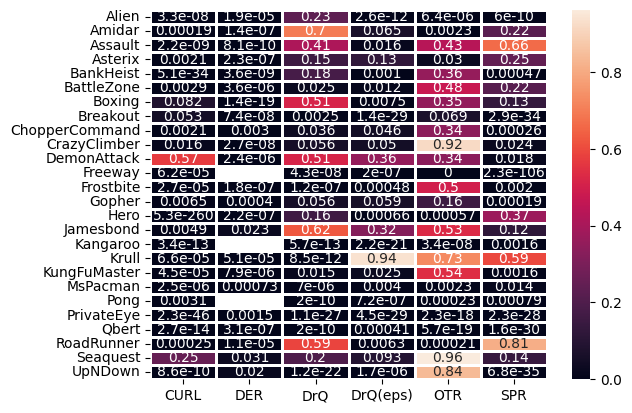

In [9]:

p_vals = np.zeros((M, len(algo_list)))
alpha = 0.05
trim = 0
smpl_len = 100
smpl_srt = int(smpl_len*trim/2)
smpl_end = smpl_len - smpl_srt

for alg_indx,  alg in zip(range(len(algo_list)), algo_list):
        for game_indx, game in zip(range(M), games):
                smpl = algo_bench[alg][game]
                smpl = np.sort(smpl)
                smpl = smpl[smpl_srt: smpl_end]
                _, p_vals[game_indx, alg_indx] = stats.normaltest(smpl)

fig, axs = plt.subplots(1,1)
# fig.set_figwidth(10)
# fig.set_figheight(10)
p_vals_mask = np.copy(p_vals)
p_vals_mask[p_vals <= alpha] = 0
p_vals_mask[p_vals > alpha] = 1
print(f"{np.sum(p_vals>alpha)} samples from a normal distribution out of {np.size(p_vals)}")
sns.heatmap(p_vals, linewidth=1, annot=True, xticklabels=algo_list, yticklabels=games, ax=axs)

In [10]:
print(f"{np.sum(p_vals<0.001)} samples from a normal distribution out of {np.size(p_vals)}")


70 samples from a normal distribution out of 156


# Equality of distributions between algorithm runs

We perform the Kolgorov Smirnov test to check whether the sample distribution resulting from applying different algorithm on the same benchmark is different or the same.

C:\Users\romeo\AppData\Local\Temp\ipykernel_6184\79482786.py:24: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  _, p_vals[i] = stats.ks_2samp(alg1_smpl, alg2_smpl, alternative='two-sided', method='exact')


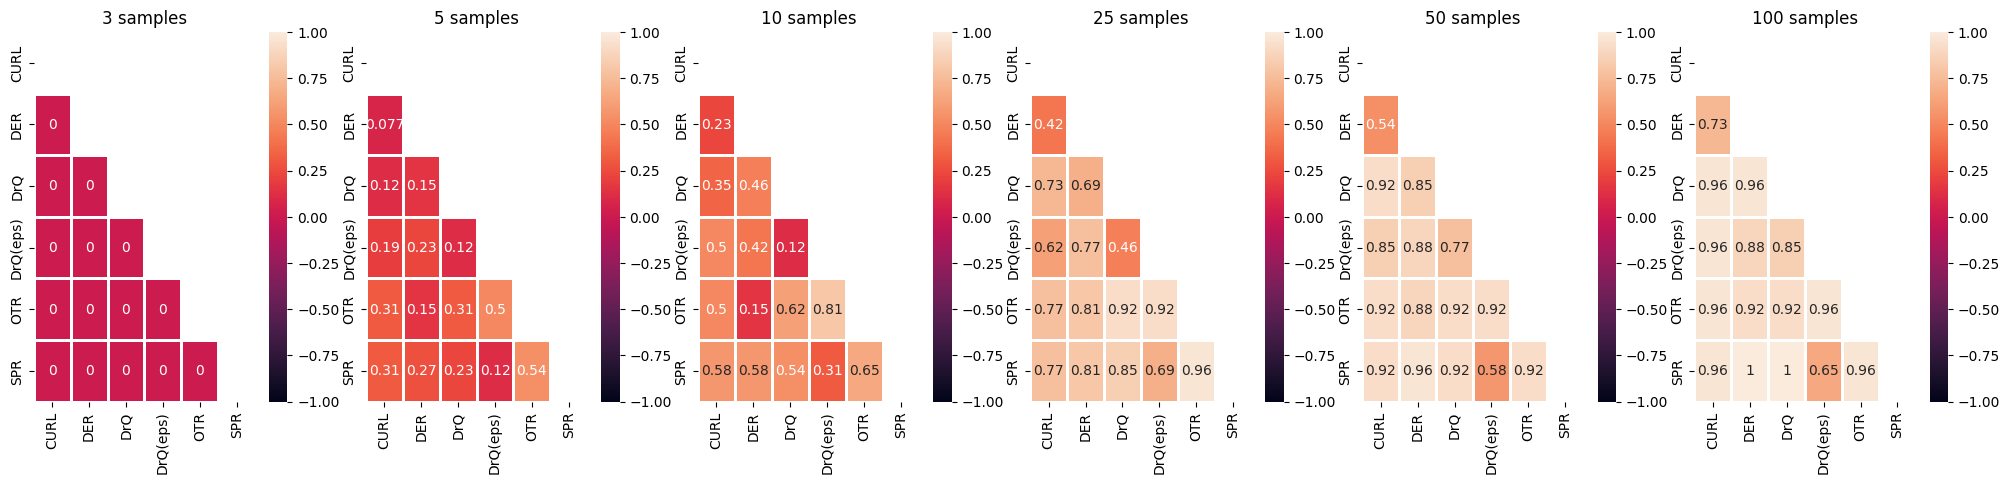

In [11]:
games = list(rain_ret.keys())
p_vals = np.zeros(len(games))
alpha = 0.05
M = len(games)
Nalgo = len(algo_bench.items())
algo_list = list(algo_bench.keys())
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        M_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        _, p_vals[i] = stats.ks_2samp(alg1_smpl, alg2_smpl, alternative='two-sided', method='exact')
                J_score = np.sum(p_vals <= alpha)/M
                J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

With enough samples even the little differences are statistically significant. So with 100 points the sample distribution resulting from applying different algorithms are always significantly different. This is a common problem in RL algorithms and due to their high variability.


# Multiple parameters test

Carica tutti i punti di simulazione.
Di seguito solamente caricati Rainbow, DER e CURL per iniziare.

Confronto tra Rainbow e DER

**WARNING** Il test deve valutare se la media è maggiore o minore. Non basta vedere che sono differenti. Per questo motivo selezioni come alternative hypothesis "less".

**WARNING** Yuen T Test è un test trimmed mean che é più robusto contro non-normalità. (TBC)

**WARNING** I diversi task non seguono spesso una distribuzione "normale"


Nel paper Stat Prec. viene usato l'IQM (inter quartile mean). E' analogo all'uso di trimming (Yuen test)?

In [12]:
games = list(rain_ret.keys())
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
K = 10    # Number or samples from the simulation
ttr = 0.1 # Trim value
alpha = 0.05
M = len(games)


for i, game in zip(range(len(games)), games):
        rain_smpl = random.sample(rain_ret[game], K)
        curl_smpl = random.sample(curl_ret[game], K)
        der_smpl = random.sample(der_ret[game], K)
        _, p_vals_great[i] = stats.ttest_ind(curl_smpl, der_smpl, equal_var=False, alternative='greater', trim=ttr)
        _, p_vals_less[i] = stats.ttest_ind(curl_smpl, der_smpl, equal_var=False, alternative='less', trim=ttr)
        _, p_vals_mood_great[i] = stats.mood(curl_smpl, der_smpl, alternative='greater')
        _, p_vals_mood_less[i] = stats.mood(curl_smpl, der_smpl, alternative='less')

In [13]:

idx_great = p_vals_great < alpha/2 # We divide by two applying the Bonferroni correction for multiple (two) tests.
idx_less = p_vals_less < alpha/2   # We divide by two applying the Bonferroni correction for multiple (two) tests.
idx_equal = (p_vals_great > alpha) & (p_vals_less > alpha)

if (idx_equal & idx_great | idx_equal & idx_less | idx_great & idx_less).any():
    raise ValueError



print(f'Mean test: Out of {len(games)} tests, {np.sum(idx_great)} accept the higher alternate hypothesis, {np.sum(idx_less)} accept the lesser alternate hypothesis and {np.sum(idx_equal)} accept the null hypothesis ')
print()

Mean test: Out of 26 tests, 9 accept the higher alternate hypothesis, 2 accept the lesser alternate hypothesis and 12 accept the null hypothesis 



In [14]:
alpha_crr = alpha/2


# Mean test
sorted_p_vals = np.sort(p_vals_great)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True) 
fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

sorted_p_vals = np.sort(p_vals_less)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True) 
fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

score = (fdr_idx_less - fdr_idx_great)/M

print(f'Mean test:  Relative discoveries {score}')

Mean test:  Relative discoveries 0.0


E' proposta la metrica J = (fdr_idx_great - fdr_idx_less)/M.
NB questa metrica non tiene conto del valore assoluto di differenza tra i due algoritmi o di risultato tra i diversi game/task.

Si potrebbe anche usare una funzione f(J) che renda non lineare la risposta. Ovvero J piccolo (es. <0.3) non è molto indicativo. Meglio "forzarlo" a zero che è più intuitivo.

Plot della variazione per numero K diversi.

In [5]:
def relat_discov (alpha, p_vals_great, p_vals_less):
    alpha_crr = alpha/2
    sorted_p_vals = np.sort(p_vals_great)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    sorted_p_vals = np.sort(p_vals_less)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    score = (fdr_idx_great - fdr_idx_less)/M
    return score

In [6]:
def relat_improv (alpha, p_vals_great, p_vals_less, alg1_smpl_mean, alg2_smpl_mean):
    alpha_crr = alpha/2
    sorted_p_vals = np.sort(p_vals_great)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    p_vals_great_t = p_vals_great(np.where(p_vals_great==sorted_p_vals[idx]))
    fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    sorted_p_vals = np.sort(p_vals_less)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    score = (fdr_idx_great - fdr_idx_less)/M
    return score

In [7]:
def score_normalization(scores, min_scores, max_scores):
  # min should be random scores, max should be human scores.
  norm_scores = np.divide(np.subtract(scores, min_scores), max_scores - min_scores)
  return norm_scores

c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a, g, axis)
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a, g, axis)
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a

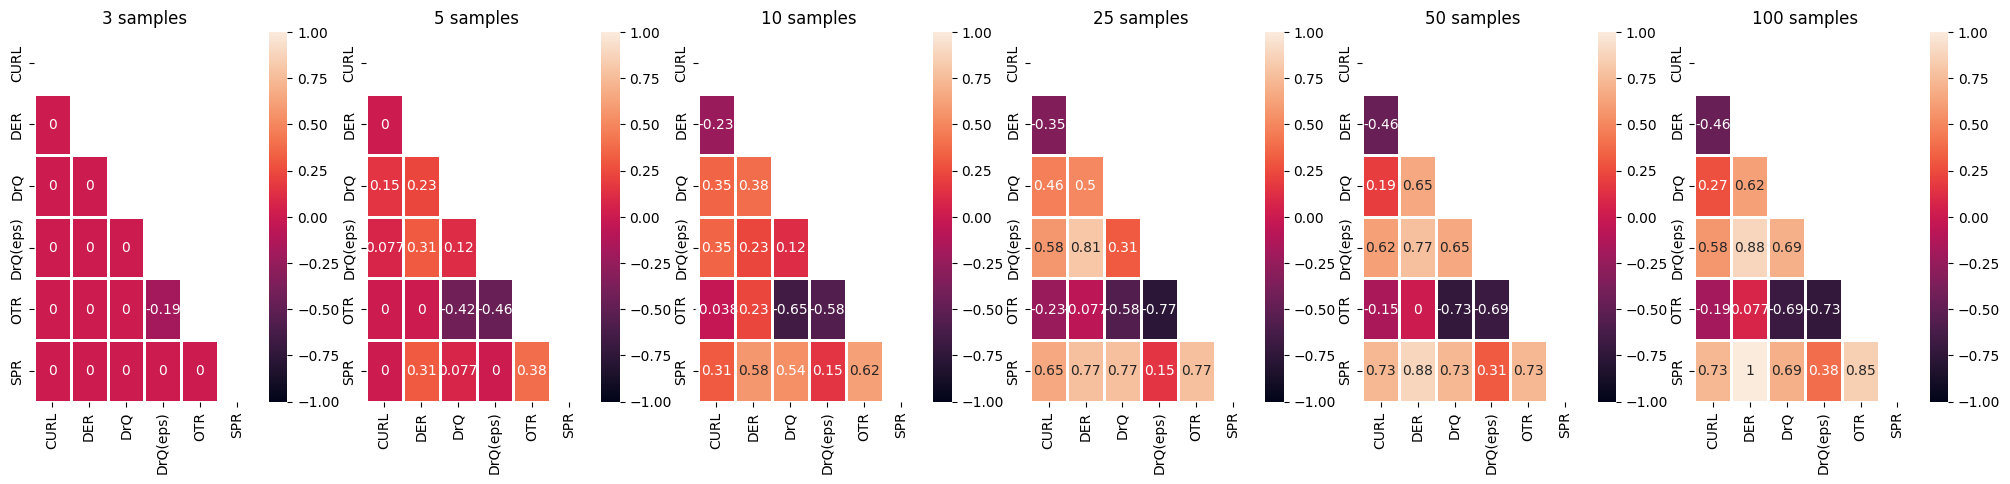

In [18]:
games = list(rain_ret.keys())
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
M = len(games)
Nalgo = len(algo_bench.items())
algo_list = list(algo_bench.keys())
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        M_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        _, p_vals_great[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='greater', trim=ttr)
                        _, p_vals_less[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='less', trim=ttr)
                        # _, p_vals_mood_great[i] = stats.mood(curl_smpl, der_smpl, alternative='greater')
                        # _, p_vals_mood_less[i] = stats.mood(curl_smpl, der_smpl, alternative='less')

                J_score = relat_discov (alpha, p_vals_great, p_vals_less)
                J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

<Axes: >

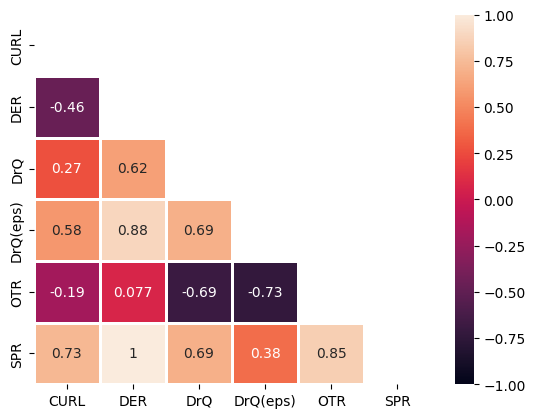

In [19]:

sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list)


c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a, g, axis)
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a, g, axis)
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_stats_py.py:6843: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a

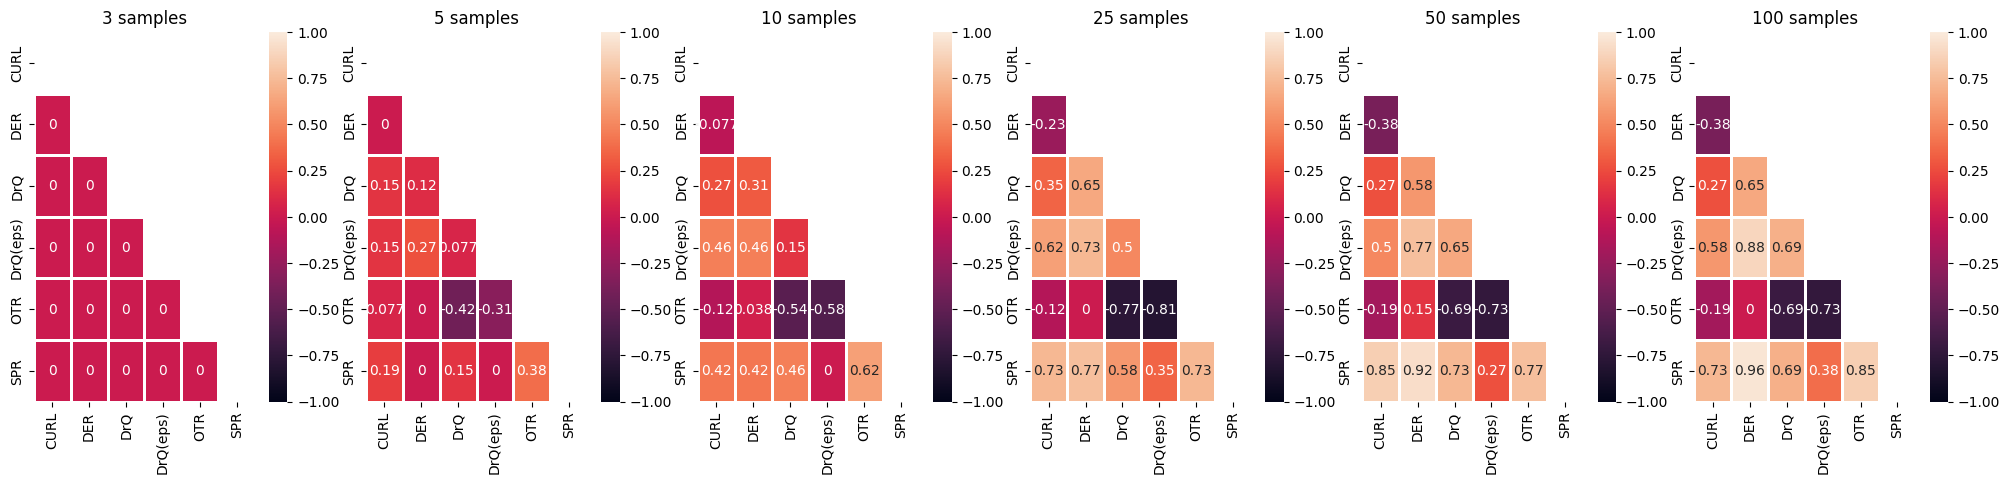

In [20]:
alg1_smpl_mean = np.zeros(len(games))
alg2_smpl_mean = np.zeros(len(games))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg1_smpl_mean[i] = np.mean(alg1_smpl)
                        alg2_smpl_mean[i] = np.mean(alg2_smpl)
                        _, p_vals_great[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='greater', trim=ttr)
                        _, p_vals_less[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='less', trim=ttr)

                        J_score = relat_discov (alpha, p_vals_great, p_vals_less)
                        J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

In [21]:
mean_a = np.zeros(M)
alpha_crr = alpha/2
sorted_p_vals = np.sort(p_vals_great)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True)
p_vals_great_t = p_vals_great[np.where(p_vals_great==sorted_p_vals[np.max(idx)])]
idx_great = p_vals_great<= p_vals_great_t
mean_a[idx_great] = np.divide(alg2_smpl_mean - alg1_smpl_mean, alg1_smpl_mean)[idx_great]
# fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

# sorted_p_vals = np.sort(p_vals_less)
# L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
# idx = np.where(L_arr == True)
# fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

# score = (fdr_idx_great - fdr_idx_less)/M

## Mann-Withney test
The Welch test is robust against non normality in data. The assumptions are however not met. This is especially a problem with small samples. We can use another test such as the Wilcoxon-Mann-Whitney test which is a nonparametric test and does not assume normally distributed data.

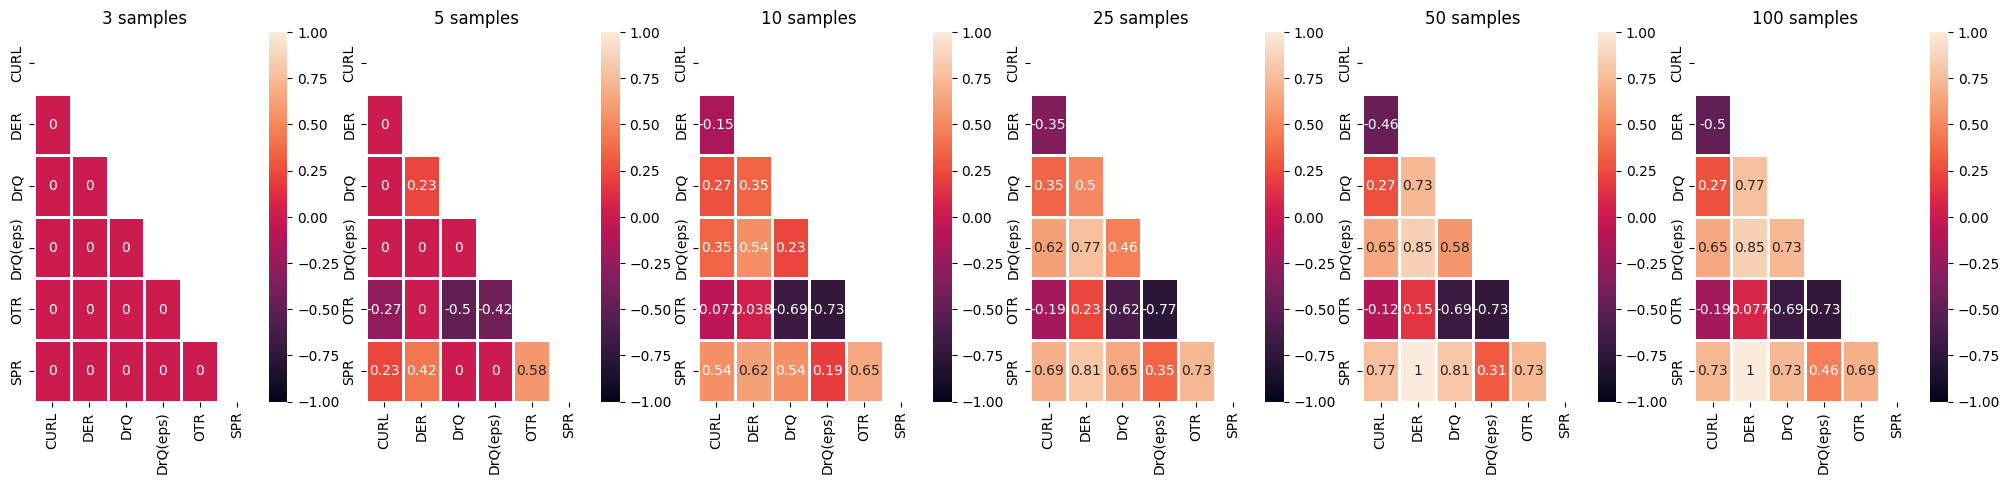

In [22]:
alg1_smpl_mean = np.zeros(len(games))
alg2_smpl_mean = np.zeros(len(games))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg1_smpl_mean[i] = np.mean(alg1_smpl)
                        alg2_smpl_mean[i] = np.mean(alg2_smpl)

                        _, p_vals_great[i] = stats.mannwhitneyu(alg2_smpl, alg1_smpl, use_continuity=True, alternative='greater', method='exact', keepdims=False)
                        _, p_vals_less[i] = stats.mannwhitneyu(alg2_smpl, alg1_smpl, use_continuity=True, alternative='less', method='exact', keepdims=False)

                        J_score = relat_discov (alpha, p_vals_great, p_vals_less)
                        J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

# Wilcoxon signed-ranks test
We follow the approach of Demsar 2006. We perform Wilcoxon signed-rank tests on the different datasets. Each observation within the sample is the mean/median score on a benchmark game. So the number of observations is equal to the number of games.

c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\romeo\OneDrive\Documents\Universita\Thesis\stat_prec\pyenv\lib\site-packages\scipy\stats\_moresta

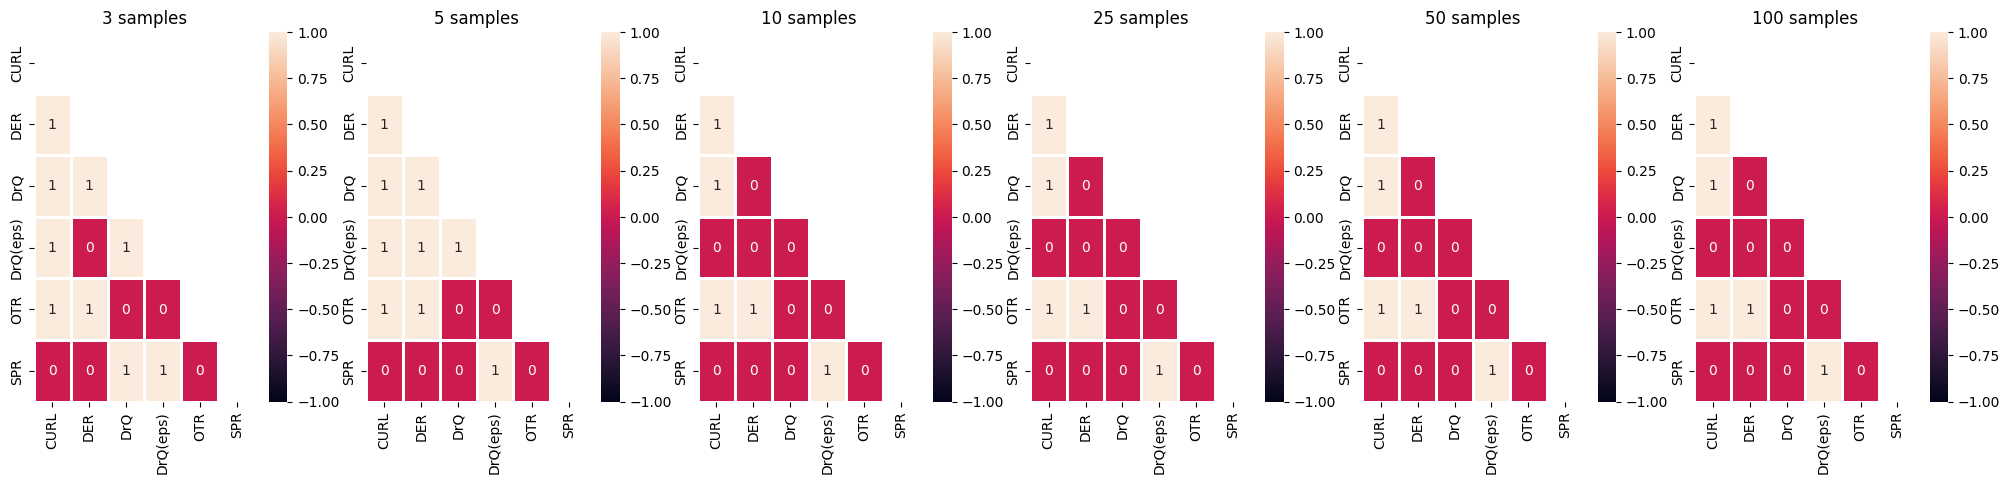

In [23]:
combs = math.factorial(len(algo_list))/math.factorial(len(algo_list)-2)/2

alg1_smpl_mean = np.zeros(len(games))
alg1_smpl_median = np.zeros(len(games))
alg2_smpl_mean = np.zeros(len(games))
alg2_smpl_median = np.zeros(len(games))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
alpha_bonf = alpha/combs
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg1_smpl_mean[i] = np.mean(alg1_smpl)
                        alg1_smpl_median[i] = np.median(alg1_smpl)
                        alg2_smpl_mean[i] = np.mean(alg2_smpl)
                        alg2_smpl_median[i] = np.median(alg2_smpl)
                _, p_val = stats.wilcoxon(alg1_smpl_median, alg2_smpl_median)

                J_score = 0 if p_val<= alpha_bonf else 1
                J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

# Sign test
We follow the approach of Demsar 2006. We perform the Sign test on the different datasets. Each observation within the sample is the mean/median score on a benchmark game. So the number of observations is equal to the number of games.
The sign tests counts the number of times an algorithm is better than the other.

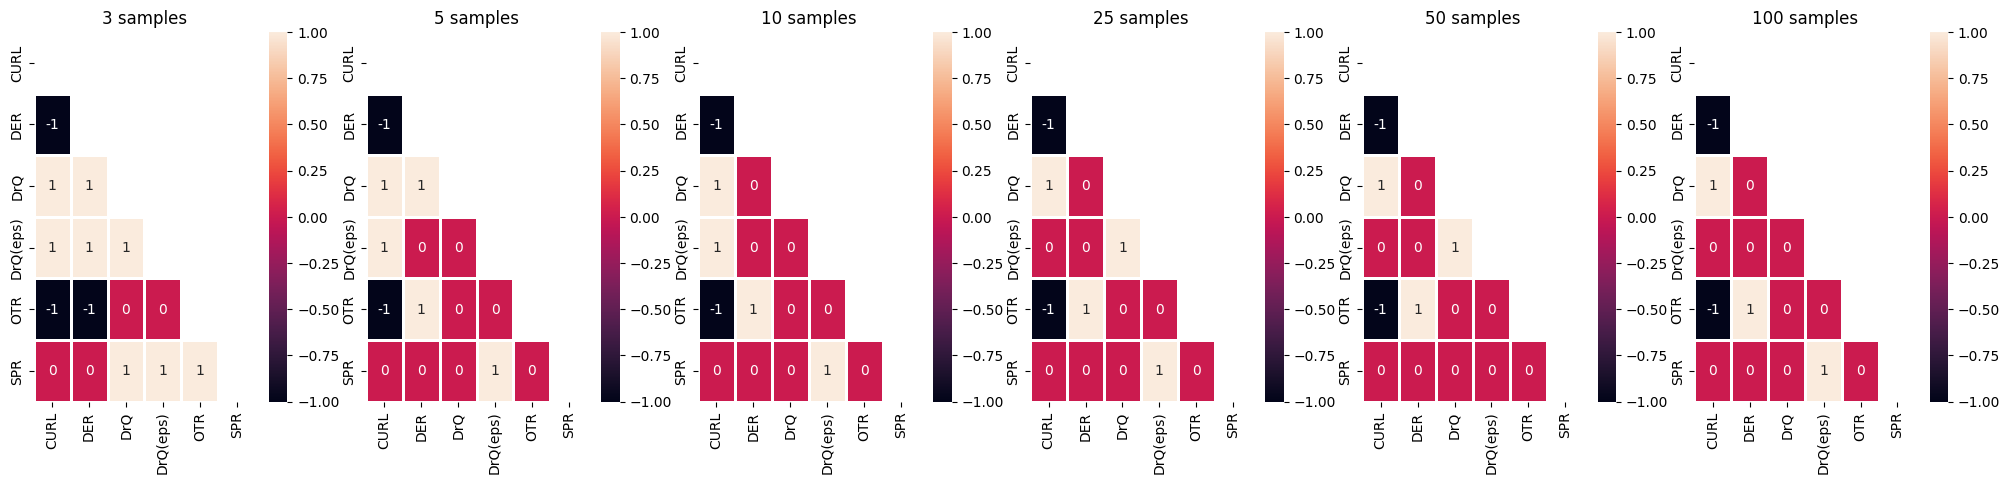

In [24]:
combs = math.factorial(len(algo_list))/math.factorial(len(algo_list)-2)/2

alg1_smpl_mean = np.zeros(len(games))
alg1_smpl_median = np.zeros(len(games))
alg2_smpl_mean = np.zeros(len(games))
alg2_smpl_median = np.zeros(len(games))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
alpha_bonf = alpha/combs
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg1_smpl_mean[i] = np.mean(alg1_smpl)
                        alg1_smpl_median[i] = np.median(alg1_smpl)
                        alg2_smpl_mean[i] = np.mean(alg2_smpl)
                        alg2_smpl_median[i] = np.median(alg2_smpl)
                signs = np.sign(alg2_smpl_median - alg1_smpl_median)
                if np.sum(signs) >= 0:
                        wins = np.sum(signs>0)
                        results = stats.binomtest(wins, len(games), 0.5)
                        p_val = results.pvalue
                        J_score = 0 if p_val<= alpha_bonf else 1
                else:
                       wins = np.sum(signs<0)
                       results = stats.binomtest(wins, len(games), 0.5)
                       p_val = results.pvalue
                       J_score = 0 if p_val<= alpha_bonf else -1
                J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

# Friedman test


In [10]:
alg_smpl_mean = np.zeros((Nalgo, len(games)))
alg_smpl_median = np.zeros((Nalgo, len(games)))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
Kv = np.array([3, 5, 10, 25, 50, 100])
# fig, ax = plt.subplots(1, len(Kv))
# fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        for alg in algo_bench.keys():
                alg_ret = algo_bench[alg]
                j = algo_list.index(alg)
                for i, game in zip(range(len(games)), games):
                        alg_smpl = random.sample(alg_ret[game], K)
                        alg_smpl = score_normalization(alg_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg_smpl_mean[j, i] = np.mean(alg_smpl)
                        alg_smpl_median[j, i] = np.median(alg_smpl)
        _, p_val = stats.friedmanchisquare(alg_smpl_mean[0, :], alg_smpl_mean[1, :],alg_smpl_mean[2, :], alg_smpl_mean[3, :], alg_smpl_mean[4, :], alg_smpl_mean[5, :])
        _, p_val = stats.friedmanchisquare(alg_smpl_median[0, :], alg_smpl_median[1, :],alg_smpl_median[2, :], alg_smpl_median[3, :], alg_smpl_median[4, :], alg_smpl_median[5, :])
        print(f'P value of Friedman test with {K} number of observations: {p_val}')


P value of Friedman test with 3 number of observations: 7.2715127746701505e-09
P value of Friedman test with 5 number of observations: 1.9690267966609343e-10
P value of Friedman test with 10 number of observations: 1.2238365074602711e-09
P value of Friedman test with 25 number of observations: 3.788176298212349e-12
P value of Friedman test with 50 number of observations: 2.185174227893612e-12
P value of Friedman test with 100 number of observations: 1.368375016636959e-12


In [11]:
CRITICAL_VALUES = [
# p   0.01   0.05   0.10  Models
    [2.576, 1.960, 1.645], # 2
    [2.913, 2.344, 2.052], # 3
    [3.113, 2.569, 2.291], # 4
    [3.255, 2.728, 2.460], # 5
    [3.364, 2.850, 2.589], # 6
    [3.452, 2.948, 2.693], # 7
    [3.526, 3.031, 2.780], # 8
    [3.590, 3.102, 2.855], # 9
    [3.646, 3.164, 2.920], # 10
    [3.696, 3.219, 2.978], # 11
    [3.741, 3.268, 3.030], # 12
    [3.781, 3.313, 3.077], # 13
    [3.818, 3.354, 3.120], # 14
    [3.853, 3.391, 3.159], # 15
    [3.884, 3.426, 3.196], # 16
    [3.914, 3.458, 3.230], # 17
    [3.941, 3.489, 3.261], # 18
    [3.967, 3.517, 3.291], # 19
    [3.992, 3.544, 3.319], # 20
    [4.015, 3.569, 3.346], # 21
    [4.037, 3.593, 3.371], # 22
    [4.057, 3.616, 3.394], # 23
    [4.077, 3.637, 3.417], # 24
    [4.096, 3.658, 3.439], # 25
    [4.114, 3.678, 3.459], # 26
    [4.132, 3.696, 3.479], # 27
    [4.148, 3.714, 3.498], # 28
    [4.164, 3.732, 3.516], # 29
    [4.179, 3.749, 3.533], # 30
    [4.194, 3.765, 3.550], # 31
    [4.208, 3.780, 3.567], # 32
    [4.222, 3.795, 3.582], # 33
    [4.236, 3.810, 3.597], # 34
    [4.249, 3.824, 3.612], # 35
    [4.261, 3.837, 3.626], # 36
    [4.273, 3.850, 3.640], # 37
    [4.285, 3.863, 3.653], # 38
    [4.296, 3.876, 3.666], # 39
    [4.307, 3.888, 3.679], # 40
    [4.318, 3.899, 3.691], # 41
    [4.329, 3.911, 3.703], # 42
    [4.339, 3.922, 3.714], # 43
    [4.349, 3.933, 3.726], # 44
    [4.359, 3.943, 3.737], # 45
    [4.368, 3.954, 3.747], # 46
    [4.378, 3.964, 3.758], # 47
    [4.387, 3.973, 3.768], # 48
    [4.395, 3.983, 3.778], # 49
    [4.404, 3.992, 3.788], # 50
]

In [12]:
ranks = stats.rankdata(alg_smpl_median, axis=0)
avg_rank = np.mean(ranks, axis=1) # Higher Rank means better 
cd = CRITICAL_VALUES[4][1] * np.sqrt(Nalgo*(Nalgo+1)/6/len(games))


Text(0, 0, 'SPR')

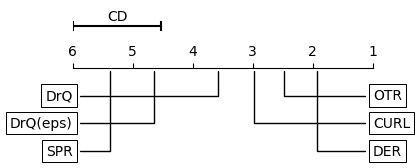

In [13]:
limits=(6, 1)
fig, ax = plt.subplots(figsize=(5,1.8))
plt.subplots_adjust(left=0.2, right=0.8)

# set up plot
ax.set_xlim(limits)
ax.set_ylim(0,1)
ax.spines['top'].set_position(('axes', 0.6))
#ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_visible(False)
for pos in ["bottom", "left", "right"]:
    ax.spines[pos].set_visible(False)

# # CD bar
ax.plot([limits[0],limits[0]-cd], [.9,.9], color="k")
ax.plot([limits[0],limits[0]], [.9-0.03,.9+0.03], color="k")
ax.plot([limits[0]-cd,limits[0]-cd], [.9-0.03,.9+0.03], color="k") 
ax.text(limits[0]-cd/2., 0.92, "CD", ha="center", va="bottom") 

# # annotations
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=90")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, va="center")
ax.annotate(algo_list[0], xy=(avg_rank[0], 0.6), xytext=(1, 0.2),ha="left",  **kw)
ax.annotate(algo_list[1], xy=(avg_rank[1], 0.6), xytext=(1, 0),ha="left",  **kw)
ax.annotate(algo_list[2], xy=(avg_rank[2], 0.6), xytext=(0 ,0.4),ha="right",  **kw)
ax.annotate(algo_list[3], xy=(avg_rank[3], 0.6), xytext=(0,0.2),ha="right",  **kw)
ax.annotate(algo_list[4], xy=(avg_rank[4], 0.6), xytext=(1,0.4),ha="left",  **kw)
ax.annotate(algo_list[5], xy=(avg_rank[5], 0.6), xytext=(0,0),ha="right",  **kw)

In [14]:
algo_list


['CURL', 'DER', 'DrQ', 'DrQ(eps)', 'OTR', 'SPR']

# Mack-Skillings Test 
Taken from section 7.9 a distribution-free test for general alternatives in a randomized block design with an equal number c(>1) of replications per treatment–block combination.
 Tratto dal libro (Wiley Series in Probability and Statistics) Myles Hollander, Douglas A. Wolfe, Eric Chicken - Nonparametric Statistical Methods-John Wiley & Sons (2014). pagina 354.


In this context the treatment refers to a different algorithm. Each block is a different benchmark.
The test assumptions are violated here because it assumes that the data distribution is the same except for some scaling parameters. We saw this to be not true.

In [15]:
# Values obtained from the cMackSkil function of NSM3 package in R.
ms_a_3 = np.mean([11.03554, 10.94647, 11.05173, 10.95547, 10.93027]) # with C = 3
ms_a_5 = np.mean([11.14581, 11.05052, 11.0797, 11.13032, 10.9868]) # with C = 5
ms_a_10 = np.mean([11.26842, 10.94618, 11.03627, 10.94774, 11.14434]) # with C = 10
ms_a_25 = np.mean([11.10433, 11.05634, 10.98652, 10.99171, 11.22652]) # with C = 25
ms_a_50 = np.mean([10.85251, 11.25274, 11.05896, 10.89352, 11.00516]) # with C = 50
ms_a_100 = np.mean([11.16238, 10.98872, 11.02136, 11.08841, 11.10868]) # with C = 100

ms_a_v = [ms_a_3, ms_a_5, ms_a_10, ms_a_25, ms_a_50, ms_a_100]

q_a = 4.031 # orbtained from the cRangeNor function of NMS3 package in R. Not dependent on number of blocks or c_{ij}


In [16]:
# Organize the data by "block" i.e. by benchmark game. Each row of observ will have results from one game.
kk = 2
K = Kv[kk]
print(f'Number of samples per block: {K}')
observ = np.zeros((len(games), len(algo_list)*K))
for game, i in zip(games, range(len(games))):
    for alg, j in zip(algo_list, range(len(algo_list))):
        observ[i, j*K:j*K+K] = random.sample(algo_bench[alg][game], K)
        # observ[i, j*K:j*K+K] = algo_bench[alg][game][:K]

Number of samples per block: 10


In [17]:
ranks = stats.rankdata(observ, axis=1) # rank 1 corrisponde al valore piu' piccolo
ranks = -np.add(ranks, -np.max(ranks+1)) # rank 1 adesso é il migliore

avg_rank = np.zeros((len(games), len(algo_list)))
for i in range(len(games)):
    for j in range(len(algo_list)):
        avg_rank[i, j] = np.mean(ranks[i, j*K: j*K+K])

S = np.mean(avg_rank, axis=0)*len(games)


In [18]:
# k=treatments, n=blocks, c=observations per block per treatment
N = K*len(games)*len(algo_list)
MS = 12/(Nalgo*(N+len(games)))*np.sum(np.power(S,2)) -3*(N+len(games))
if MS >= ms_a_v[kk]:
    print(f'The null hypothesis is rejected. MS ({MS}) > ms_a ({ms_a_v[kk]})')
else:
    print(f'The null hypothesis is NOT rejected. MS ({MS}) < ms_a ({ms_a_v[kk]})')



The null hypothesis is rejected. MS (391.395163934425) > ms_a (11.06859)


In [19]:
algo_list

['CURL', 'DER', 'DrQ', 'DrQ(eps)', 'OTR', 'SPR']

In [20]:
cd = q_a*(Nalgo*(N+len(games))/12)**0.5


Text(1, 0.4, 'SPR')

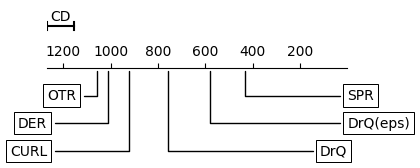

In [21]:
limits=(np.max(S)*1.2, 1)
fig, ax = plt.subplots(figsize=(5,1.8))
plt.subplots_adjust(left=0.2, right=0.8)

# set up plot
ax.set_xlim(limits)
ax.set_ylim(0,1)
ax.spines['top'].set_position(('axes', 0.6))
#ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_visible(False)
for pos in ["bottom", "left", "right"]:
    ax.spines[pos].set_visible(False)

# # CD bar
ax.plot([limits[0],limits[0]-cd], [.9,.9], color="k")
ax.plot([limits[0],limits[0]], [.9-0.03,.9+0.03], color="k")
ax.plot([limits[0]-cd,limits[0]-cd], [.9-0.03,.9+0.03], color="k") 
ax.text(limits[0]-cd/2., 0.92, "CD", ha="center", va="bottom") 

# # annotations
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=90")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, va="center")
ax.annotate(algo_list[0], xy=(S[0], 0.6), xytext=(0, 0),ha="right",  **kw) # CURL
ax.annotate(algo_list[1], xy=(S[1], 0.6), xytext=(0, 0.2),ha="right",  **kw) # DER 
ax.annotate(algo_list[2], xy=(S[2], 0.6), xytext=(1 ,0),ha="right",  **kw) # DrQ
ax.annotate(algo_list[3], xy=(S[3], 0.6), xytext=(1, 0.2),ha="left",  **kw) # DrQ(eps)
ax.annotate(algo_list[4], xy=(S[4], 0.6), xytext=(0, 0.4),ha="left",  **kw) # OTR
ax.annotate(algo_list[5], xy=(S[5], 0.6), xytext=(1,0.4),ha="left",  **kw) # SPR

In [22]:
cd

113.51399064873016

In [23]:
S

array([ 921.6 , 1011.05,  757.15,  581.4 , 1055.9 ,  430.9 ])

In [24]:
from copy import deepcopy
random.seed(1)
data_bench = deepcopy(algo_bench)
data = dict()
for kk in range(len(Kv)):
        data[kk] = deepcopy(algo_bench) 

for kk in range(len(Kv)-1): # Cannot do this until 100. We have to stop at 50.
        K = Kv[kk]
        for game, i in zip(games, range(len(games))):
                for alg, j in zip(algo_list, range(len(algo_list))):
                        data[kk][alg][game] = random.sample(data_bench[alg][game], K)
                        for xx in data[kk][alg][game]:
                                data_bench[alg][game].remove(xx)
       

In [25]:
def plot_ranks(ax, S, cd, kk):
    # Kv = np.array([3, 5, 10, 25, 50, 100])

    limits=(np.max(S)*1.2, 1)
    # fig, ax = plt.subplots(figsize=(5,1.8))
    plt.subplots_adjust(left=0.2, right=0.8)
    # set up plot
    ax.set_xlim(limits)
    ax.set_ylim(0,1)
    ax.spines['top'].set_position(('axes', 0.6))
    #ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_visible(False)
    for pos in ["bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)

    # # CD bar
    ax.plot([limits[0],limits[0]-cd], [.9,.9], color="k")
    ax.plot([limits[0],limits[0]], [.9-0.03,.9+0.03], color="k")
    ax.plot([limits[0]-cd,limits[0]-cd], [.9-0.03,.9+0.03], color="k") 
    ax.text(limits[0]-cd/2., 0.92, "CD", ha="center", va="bottom") 

    # # annotations
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=90")
    kw = dict(xycoords='data',textcoords="axes fraction",
            arrowprops=arrowprops, bbox=bbox_props, va="center")
    ax.annotate(algo_list[0], xy=(S[0], 0.6), xytext=(0, 0),ha="right",  **kw) # CURL
    ax.annotate(algo_list[1], xy=(S[1], 0.6), xytext=(0, 0.2),ha="right",  **kw) # DER 
    ax.annotate(algo_list[2], xy=(S[2], 0.6), xytext=(1 ,0),ha="right",  **kw) # DrQ
    ax.annotate(algo_list[3], xy=(S[3], 0.6), xytext=(1, 0.2),ha="left",  **kw) # DrQ(eps)
    ax.annotate(algo_list[4], xy=(S[4], 0.6), xytext=(0, 0.4),ha="left",  **kw) # OTR
    ax.annotate(algo_list[5], xy=(S[5], 0.6), xytext=(1,0.4),ha="left",  **kw) # SPR
    ax.set_title(f"Algorithm ranking with C = {Kv[kk]}")

Working with K = 3
Printing S: [274.5        315.83333333 244.16666667 187.66666667 325.66666667
 134.16666667]
The null hypothesis is rejected. MS (113.12775528565021) > ms_a (10.983895999999998)
Critical difference = 63.352137825017394
Working with K = 5
Printing S: [470.8 527.8 368.1 311.5 512.8 227. ]
The null hypothesis is rejected. MS (180.63071960297702) > ms_a (11.07863)
Critical difference = 80.92176025643535
Working with K = 10
Printing S: [ 888.45 1024.05  747.15  598.25 1024.05  476.05]
The null hypothesis is rejected. MS (323.28624842370755) > ms_a (11.06859)
Critical difference = 113.51399064873016
Working with K = 25
Printing S: [2226.18 2614.94 1846.68 1392.78 2562.3  1135.12]
The null hypothesis is rejected. MS (956.4525986754961) > ms_a (11.073084)
Critical difference = 178.59650176585205
Working with K = 50
Printing S: [4449.83 5170.14 3568.26 2832.88 5156.66 2300.23]
The null hypothesis is rejected. MS (1866.038737285966) > ms_a (11.012578)
Critical difference = 252

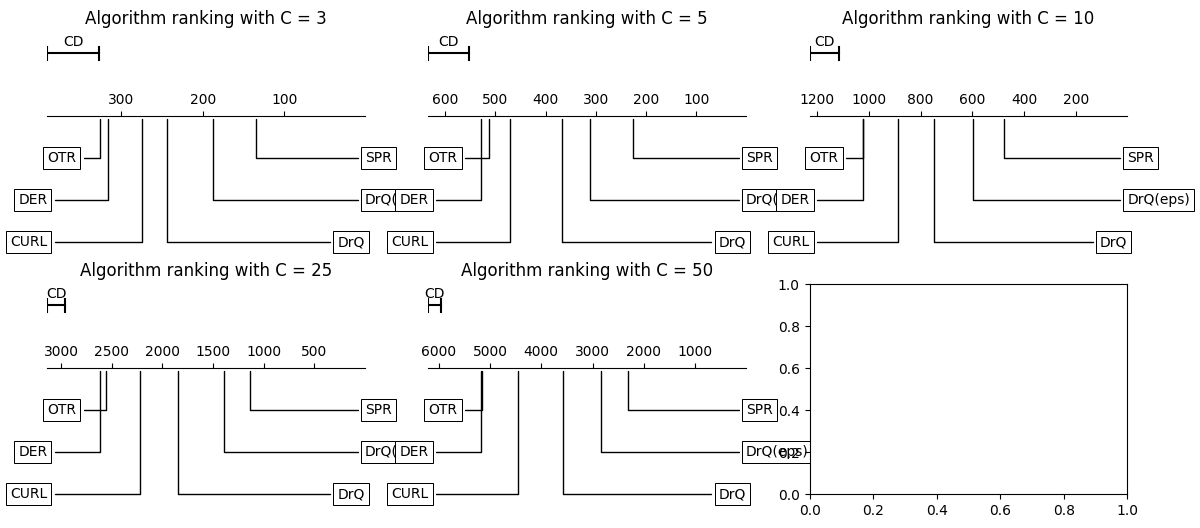

In [28]:
fig, ax = plt.subplots(2,3, squeeze=True, figsize=(18,6))
ax = list([ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]])

for kk in range(len(Kv)-1):
    K = Kv[kk]
    N = K*len(games)*len(algo_list)
    observ = np.zeros((len(games), len(algo_list)*K))
    avg_rank = np.zeros((len(games), len(algo_list)))
    data_kk = data[kk]

    print(f"Working with K = {K}")
    for game, i in zip(games, range(len(games))):
        for alg, j in zip(algo_list, range(len(algo_list))):
            # observ[i, j*K:j*K+K] = random.sample(algo_bench[alg][game], K)
            observ[i, j*K:j*K+K] = data_kk[alg][game][:K]
    ranks = stats.rankdata(observ, axis=1) # rank 1 corrisponde al valore piu' piccolo
    ranks = -np.add(ranks, -np.max(ranks+1)) # rank 1 adesso é il migliore
    # print(np.sum(Kv[:kk]))

    for i in range(len(games)):
        for j in range(len(algo_list)):
            avg_rank[i, j] = np.mean(ranks[i, j*K: j*K+K])

    S = np.mean(avg_rank, axis=0)*len(games)
    print(f"Printing S: {S}")
    # k=treatments, n=blocks, c=observations per block per treatment
    MS = 12/(Nalgo*(N+len(games)))*np.sum(np.power(S,2)) -3*(N+len(games))
    if MS >= ms_a_v[kk]:
        print(f'The null hypothesis is rejected. MS ({MS}) > ms_a ({ms_a_v[kk]})')
    else:
        print(f'The null hypothesis is NOT rejected. MS ({MS}) < ms_a ({ms_a_v[kk]})')
    
    cd = q_a*(Nalgo*(N+len(games))/12)**0.5
    print(f"Critical difference = {cd}")
    
    plot_ranks(ax[kk], S, cd, kk)




In [29]:
algo_list

['CURL', 'DER', 'DrQ', 'DrQ(eps)', 'OTR', 'SPR']

In [30]:
598.25- 476.05

122.19999999999999

In [ ]:
274.5        315.83333333 244.16666667 187.66666667 325.66666667
 134.16666667